# Data Mining Final Group Project

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats.contingency import crosstab
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import aic
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

The following code loads the data, then drops rows with null values, cleans the data a bit to make mostly-numeric columns all numeric, and separates numerical from categorical variables for analysis and feature selection.

In [193]:
df = pd.read_csv("survey_results_public.csv")
print("Target rows with nulls:", df['Hobbyist'].isna().sum())            # relatively few nulls (45)
df = df.dropna(how='any', subset='Hobbyist')  # drop all rows in the response var col without values

print("Total Columns:", df.columns.size)

# categorical columns
cat_vars_cols = df.columns.drop(
                ['Hobbyist',
                 'Respondent', 
                 'Age', 
                 'Age1stCode',
                 'CompTotal', 
                 'ConvertedComp',
                 'WorkWeekHrs',
                 'YearsCode',
                 'YearsCodePro'])

# conversion to make these a quanititative var
df.replace(to_replace={'YearsCode': 'Less than 1 year'}, value=0.5, inplace=True)
df.replace(to_replace={'YearsCode': 'More than 50 years'}, value=55, inplace=True)
df.replace(to_replace={'YearsCodePro': 'Less than 1 year'}, value=0.5, inplace=True)
df.replace(to_replace={'YearsCodePro': 'More than 50 years'}, value=55, inplace=True)

# true values unlikely to be far from these replacements
df.replace(to_replace={'Age1stCode': 'Younger than 5 years'}, value=3, inplace=True)
df.replace(to_replace={'Age1stCode': 'Older than 85'}, value=87, inplace=True)

# quantitative columns
quant_vars_cols = ['Age',
                   'Age1stCode',
                   'CompTotal',
                   'ConvertedComp',
                   'WorkWeekHrs',
                   'YearsCode',
                   'YearsCodePro']

print("\nNumerical column null counts")
print(df[quant_vars_cols].isna().sum())

Target rows with nulls: 45
Total Columns: 61

Numerical column null counts
Age              18970
Age1stCode        6516
CompTotal        29590
ConvertedComp    29660
WorkWeekHrs      23265
YearsCode         6732
YearsCodePro     18067
dtype: int64


While our target variable has releatively few nulls, our numerical features have quite a lot. These will cause us problems in our regression fitting, so we don't have a choice but to drop those too. Even with that drop, though, we clearly still have almost 30,000 datapoints, which is still plenty to work with.

In [194]:
df.dropna(subset=quant_vars_cols, inplace=True)
print("Number of observations after drop:", df.shape[0])

# NaN's made the quantitative columns string types, so had to convert back to float
df[quant_vars_cols] = df[quant_vars_cols].astype(float)

Number of observations after drop: 29893


## Variable selection

61 columns is a lot of features! We obviously don't want this many. So, to slim down the features further, we can exclude categorical features with very high numbers of levels, since these won't really work well in a machine learning model. So let's see the number of unique values for each categorical feature:

### Categorical variable selection

In [195]:
# count number of levels on each categorical column, drop ones with high number of levels
# sorted for convenience
col_unique_counts = df[cat_vars_cols].nunique(dropna=True).sort_values(axis=0, ascending=True)
print(col_unique_counts)

MainBranch                         2
Trans                              2
NEWOtherComms                      2
CompFreq                           3
SurveyLength                       3
SurveyEase                         3
NEWOffTopic                        3
NEWOnboardGood                     3
SOAccount                          3
Employment                         3
PurchaseWhat                       3
NEWDevOps                          3
JobSeek                            3
NEWLearn                           4
OpSys                              4
NEWPurpleLink                      4
NEWOvertime                        5
NEWEdImpt                          5
JobSat                             5
NEWDevOpsImpt                      5
SOComm                             6
SOPartFreq                         6
SOVisitFreq                        6
WelcomeChange                      6
Gender                             7
EdLevel                            9
OrgSize                            9
U

Some of these variables have hundreds or even thousands of levels! Looks like we can drop about everything after `WelcomeChange`, as it has only 6 levels, and everything after has more.

In [196]:
# categorical variables with smaller number of levels up to the Sexuality column
cat_vars_cols = col_unique_counts.loc[:'WelcomeChange'].index
cat_vars_cols

Index(['MainBranch', 'Trans', 'NEWOtherComms', 'CompFreq', 'SurveyLength',
       'SurveyEase', 'NEWOffTopic', 'NEWOnboardGood', 'SOAccount',
       'Employment', 'PurchaseWhat', 'NEWDevOps', 'JobSeek', 'NEWLearn',
       'OpSys', 'NEWPurpleLink', 'NEWOvertime', 'NEWEdImpt', 'JobSat',
       'NEWDevOpsImpt', 'SOComm', 'SOPartFreq', 'SOVisitFreq',
       'WelcomeChange'],
      dtype='object')

Now we can compare each categorical variable against each other to see if which categorical variables are independent of which (if any). We'll be using $\chi ^2$ tests of independence here, the equivalent of multicolinearity tests for categorical variables. can only select variables that are indeendent of each other, or else we get multicollinearity in the model. Depending on the model, multicolinearity can result in anything from redundancy between features to misleading model results and violation of assumptions. So either way, we can use this test to eliminate features.

In [197]:
# this codeblock takes about 45s to run on my (slow) machine
# it simply conducts the tests and saves the results
num_cat_cols = len(cat_vars_cols)
chi_sq_tests = np.zeros((num_cat_cols, num_cat_cols))

for i, rows in enumerate(cat_vars_cols):
    for j, cols in enumerate(cat_vars_cols):

        row_levels = df[rows].unique()
        col_levels = df[cols].unique()
    
        ctab_result = crosstab(df[rows], df[cols],
                               levels=(
                                   row_levels[~pd.isnull(row_levels)],  # don't consider null as a level value
                                   col_levels[~pd.isnull(col_levels)]))
        
        # if there is a row or column of all zeros in the contingency table (ctab_result[1])
        # then mark the chi-squared test for that combo 0 
        # this is because there is a relationship between the two of some sort,
        # but it causes the chi-squared test to be impossible due to an implicit div-0 error

        # this conditions checks to make sure there is at least one non-zero value in each row/col
        if (np.all(ctab_result[1], axis=0).all() and np.all(ctab_result[1], axis=1).all()):
            test_results = stats.chi2_contingency(ctab_result[1])
            chi_sq_tests[i][j] = test_results[1]  # load p-values into the grid
        else:
            chi_sq_tests[i][j] = 0
            

        # this part prints the completion status
        amount_completed = 100*((num_cat_cols*i + j + 1)/num_cat_cols**2)
        print(" row:", i, 
              "col:", j, 
              "Progress: {:.2f}%".format(amount_completed),
              end="\r")  # progress

Now we can see our results. This code gives a chart of all the variables and how independent they are in terms of $\chi^2$ test $p$-values.

<Axes: >

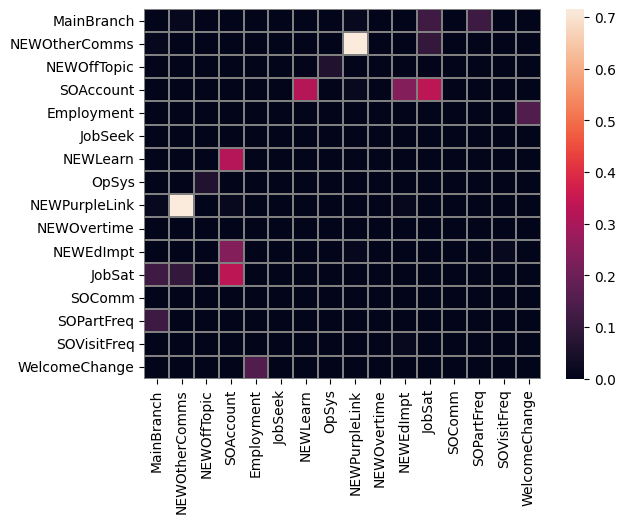

In [209]:
# redefine as a DataFrame, to have labels
chi_sq_tests = pd.DataFrame(chi_sq_tests, 
                            columns=cat_vars_cols, 
                            index=cat_vars_cols)
round(chi_sq_tests,2).to_csv('chi_sq_tests.csv')    # to save for later

sns.heatmap(chi_sq_tests, 
            #cmap=['white','black'], 
            linewidths=0.1,
            linecolor='grey')

Anything black is a non-independent combination, and anything purple or lighter is effectively independent. 

It looks like we have a few combinations to choose from, even if many are related. Let's try to slim down this list of variables first, though, and then we'll revisit this chart with the reduced set. 

Several of these question topics have to do with the subject's company, their job description, pay frequency, or the survey itself, and as such do not help clarify the individual's personality. I've taken these and listed them in the `irrelevant` list below, and removed them from our list of categorical variables.

In [200]:
irrelevant = ['NEWDevOps', 'CompFreq', 'SurveyLength', 'SurveyEase', 
              'NEWOnboardGood','PurchaseWhat', 'NEWDevOpsImpt']
cat_vars_cols = cat_vars_cols.drop(irrelevant)
print(cat_vars_cols)

Index(['MainBranch', 'Trans', 'NEWOtherComms', 'NEWOffTopic', 'SOAccount',
       'Employment', 'JobSeek', 'NEWLearn', 'OpSys', 'NEWPurpleLink',
       'NEWOvertime', 'NEWEdImpt', 'JobSat', 'SOComm', 'SOPartFreq',
       'SOVisitFreq', 'WelcomeChange'],
      dtype='object')


If this is to be a tool for employers, we probably shouldn't select a variable that uses a legally protected characteristic like `Trans`. Let's drop that one too. 

In [201]:
cat_vars_cols = cat_vars_cols.drop(['Trans'])
print(cat_vars_cols)

Index(['MainBranch', 'NEWOtherComms', 'NEWOffTopic', 'SOAccount', 'Employment',
       'JobSeek', 'NEWLearn', 'OpSys', 'NEWPurpleLink', 'NEWOvertime',
       'NEWEdImpt', 'JobSat', 'SOComm', 'SOPartFreq', 'SOVisitFreq',
       'WelcomeChange'],
      dtype='object')


Now let's take a look at our "correlation" plot from earlier, with this smaller set of variables.

<Axes: >

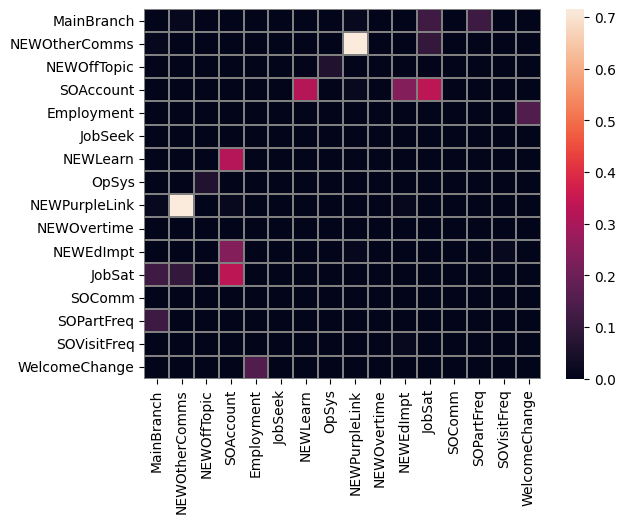

In [212]:
# this code is not filtering right yet
chi_sq_tests_reduced = chi_sq_tests.filter(items=chi_sq_tests, axis=0)
chi_sq_tests_reduced = chi_sq_tests_reduced.filter(items=chi_sq_tests, axis=1)
sns.heatmap(chi_sq_tests_reduced,  
            linewidths=0.1,
            linecolor='grey')

I don't see any here that I know I can discount as irrelevant to whether someone taking the survey is a programming hobbyist or not, so we'll leave all these for now and use a gridsearch on a set of logistic regressions, each with all the numerical variables we've chosen and one of the above categorical variables. That will tell us which one was the best choice.

### Numerical variable selection

Now we can take a look at our numerical variables, and see which ones are correlated with each other. If two variables are significantly correlated, we should not include both. The cutoff I chose is $r = 0.6$; correlations higher than that are deemed significant, with ones lower than that insignificant. So let's see what we get:

<Axes: >

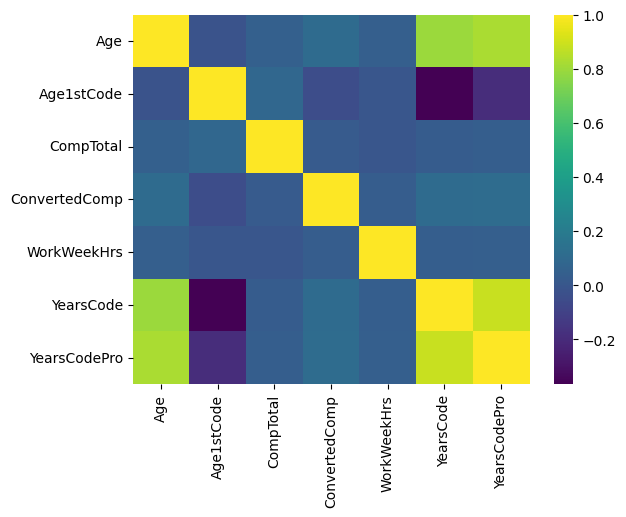

In [202]:
corr_matrix = df[quant_vars_cols].corr(numeric_only=True)
sns.heatmap(corr_matrix, cmap='viridis')

It looks like `Age` is correlated with `YearsCode` as well as `YearsCodePro` (this seems intuitive). `YearsCode` and `YearsCodePro` are correlated with each other too, so we should only choose one of the three. The rest aren't really correlated. Since `YearsCode` (years the person has been coding) seems most relevant to whether the person is a hobbyist or not, let's keep that one, and drop the other two: 

In [ ]:
quant_vars_cols = quant_vars_cols.drop(['Age','YearsCodePro'])

Further, `CompTotal` is the total compensation in the survey-taker's native currency, whereas `ConvertedComp` is the salary in USD (using the exchange rate at the time of the survey and 50 working weeks in a year). So `CompTotal` is redundant, if not useless on its own across several currencies. So we'll drop that one too.

In [ ]:
quant_vars_cols = quant_vars_cols.drop(['CompTotal'])

Now we have our variables narrowed down to something reasonable! To recap, here are our numerical variables, and our candidate categorcal variables:

In [ ]:
print("Numerical Variables:\n", quant_vars_cols)
print("\nCategorical Variables:\n", cat_vars_cols)

Numerical Variables:
 Index(['Age1stCode', 'ConvertedComp', 'WorkWeekHrs', 'YearsCode'], dtype='object')

Categorical Variables:
 Index(['NEWOtherComms', 'NEWOffTopic', 'SOAccount', 'JobSeek', 'NEWLearn',
       'OpSys', 'NEWPurpleLink', 'JobSat', 'NEWEdImpt', 'NEWOvertime',
       'MainBranch', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'WelcomeChange'],
      dtype='object')


## Model Building

### Check for imbalance in target variable

We should probably check for imbalance in the target variable (`Hobbyist`) before we get too much further. Let's see how our data is on that front:

Yes    22995
No      6898
Name: Hobbyist, dtype: int64

No's percent of target: 23.1%
Yes/No ratio: 3.334


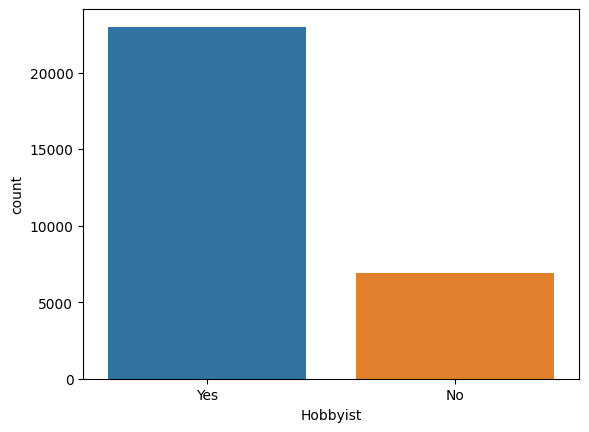

In [213]:
y_n_vals = df.Hobbyist.value_counts()
sns.countplot(df, x='Hobbyist')

print(y_n_vals)
# print("\nNo's percent of target: {:.1f}%".format(100*y_n_vals[1]/df.Hobbyist.count()))
# print("Yes/No ratio: {:.3f}".format(y_n_vals[0]/y_n_vals[1]))

print("\nNo's percent of target: {:.1f}%".format(100*y_n_vals.iloc[1]/df.Hobbyist.count()))
print("Yes/No ratio: {:.3f}".format(y_n_vals.iloc[0]/y_n_vals.iloc[1]))

So there is some imbalance, but it is relatively mild for this dataset (23% minor class, or less than 4:1 major/minor). Further, for logistic regression, balance is less of an issue than having proper sample sizes for each class, which we do, even for the smaller 'no' class ($n_\text{no}=14028$). So we probably have an accurate representation of the distribution of each. In light of that, we won't scale our data here.

### Search for best categorical variable

On to model building proper. Since we don't know which categorical variable will be best for our model, and we have few enough useable quantitative variables to use all of them with each categorical one. That means we'll need check each one to find the best. We'll see if we can pare down the quanititative variables afterward.

In [ ]:
# this block is having datatype issues, will resolve later
df['Hobbyist'] = df['Hobbyist'].map({'Yes': 1, 'No': 0})

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
print(train_data.dtypes)
x_train_quant = train_data[quant_vars.columns]
print(x_train_quant.dtypes)
x_train_quant = x_train_quant.convert_dtypes()
print(x_train_quant.dtypes)

logistic_models = []
for cat in smallest_cats:
    dummies = pd.get_dummies(train_data[cat], 
                             prefix=cat, 
                             prefix_sep='_',
                             drop_first=True)             # one-hot encoding
    x_train = x_train_quant.join(dummies)
    model = sm.Logit(endog=train_data['Hobbyist'], exog=x_train)
    model.fit()
    logistic_models.append(model)

Respondent              int64
MainBranch             object
Hobbyist              float64
Age                   float64
Age1stCode             object
                       ...   
WebframeWorkedWith     object
WelcomeChange          object
WorkWeekHrs           float64
YearsCode              object
YearsCodePro           object
Length: 61, dtype: object
Age1stCode        object
ConvertedComp    float64
WorkWeekHrs      float64
YearsCode         object
dtype: object
Age1stCode        object
ConvertedComp      Int64
WorkWeekHrs      Float64
YearsCode         object
dtype: object


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and Age1stCode            object
ConvertedComp          Int64
WorkWeekHrs          Float64
YearsCode             object
NEWOtherComms_Yes      uint8
dtype: object. The data was
31999   NaN
44025   NaN
8677    NaN
14543   NaN
31804   NaN
         ..
62610   NaN
38170   NaN
860     NaN
15795   NaN
56459   NaN
Name: Hobbyist, Length: 51532, dtype: float64
and
       Age1stCode  ConvertedComp  WorkWeekHrs YearsCode  NEWOtherComms_Yes
31999         13           <NA>         45.0        39                  0
44025         19          91883         45.0        18                  0
8677          20           <NA>         <NA>         4                  1
14543         15          50806         40.0         9                  0
31804         14          39996         32.0        25                  1
...          ...            ...          ...       ...                ...
62610         11           <NA>         <NA>        13                  0
38170         10           <NA>         35.0        23                  0
860           18         110000         40.0         9                  0
15795         13          60989         34.0         6                  0
56459         13           <NA>         40.0        17                  1

[51532 rows x 5 columns]
before. After,
[nan nan nan ... nan nan nan]
[['13' <NA> 45.0 '39' 0]
 ['19' 91883 45.0 '18' 0]
 ['20' <NA> <NA> '4' 1]
 ...
 ['18' 110000 40.0 '9' 0]
 ['13' 60989 34.0 '6' 0]
 ['13' <NA> 40.0 '17' 1]].

In [ ]:
# this code assesses the model
residual_deviance = result.deviance
degrees_of_freedom_residual = result.df_resid

# Calculate the p-value using the survival function (sf) for the chi-square distribution
p_value = chi2.sf(residual_deviance, degrees_of_freedom_residual)

print(f"Goodness-of-fit test p-value: {p_value}")

NameError: name 'result' is not defined